# N-body simulations

In [2]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.85' # NOTE: jax preallocates GPU (default 75%)
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, config as jconfig, jit, vmap, grad, debug, tree
jconfig.update("jax_enable_x64", True)

from functools import partial
from getdist import plots
from numpyro import infer

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload
from montecosmo.mcbench import sample_and_save
from montecosmo.script import from_id, get_mcmc, get_init_mcmc

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# mlflow.set_experiment("infer")
# !jupyter nbconvert --to script ./src/montecosmo/tests/infer_model.ipynb/

%matplotlib inline
%load_ext autoreload
%autoreload 2
!hostname

feynmangpu04.cluster.local


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Compensation

In [2]:
from montecosmo.model import FieldLevelModel, default_config
from montecosmo.bricks import lin_power_mesh, Planck18, lpt, nbody, cic_paint
from jaxpm.growth import growth_factor
kpks = []
a_obs = 1.

def evolve(model, params:tuple):
    cosmology, init = params

    # Create regular grid of particles
    q = jnp.indices(model.mesh_shape).reshape(3,-1).T

    # LPT displacement at a_lpt
    # NOTE: lpt assumes given mesh follows linear pk at a=1, and then correct by growth factor for target a_lpt
    cosmology._workspace = {}  # HACK: temporary fix
    dq, p, f = lpt(cosmology, **init, positions=q, a=model.a_lpt, order=model.lpt_order)
    particles = jnp.stack([q + dq, p])

    # PM displacement from a_lpt to a_obs
    particles = nbody(cosmology, model.mesh_shape, particles, model.a_lpt, model.a_obs)
    particles = particles[-1]

    # CIC paint weighted by Lagrangian bias expansion weights
    biased_mesh = cic_paint(jnp.zeros(model.mesh_shape), particles[0])
    return biased_mesh

for mesh_length in [64, 128, 256]:
    for lpt_order in [1, 2]:
        for pm in [0,1]:
            a_lpt = 0.1 if pm else a_obs
            config = {
                        'mesh_shape':3 * (mesh_length,),
                        'box_shape':3 * (640.,),
                        'a_lpt':a_lpt,
                        'a_obs':a_obs,
                        'lpt_order':lpt_order,
                        'precond':0,
                        'obs':'mesh'
                        }
            model = FieldLevelModel(**default_config | config)

            cosmology = Planck18()
            pmeshk = lin_power_mesh(cosmology, model.mesh_shape, model.box_shape)
            linmesh = jr.normal(jr.key(0), model.mesh_shape)
            linmesh = jnp.fft.rfftn(linmesh) * pmeshk**.5
            init = {'init_mesh':linmesh}
            params = cosmology, init

            mesh = evolve(model, params)
            kpk = model.spectrum(mesh, comp=True)
            kpks.append(kpk)

            D1 = growth_factor(cosmology, jnp.atleast_1d(a_obs))
            kpklin = model.spectrum(jnp.fft.irfftn(linmesh * D1))
            kpks.append(kpklin)

ImportError: cannot import name 'lpt' from 'montecosmo.bricks' (/feynman/home/dphp/hs276503/workspace/montecosmo_proj/src/montecosmo/montecosmo/bricks.py)

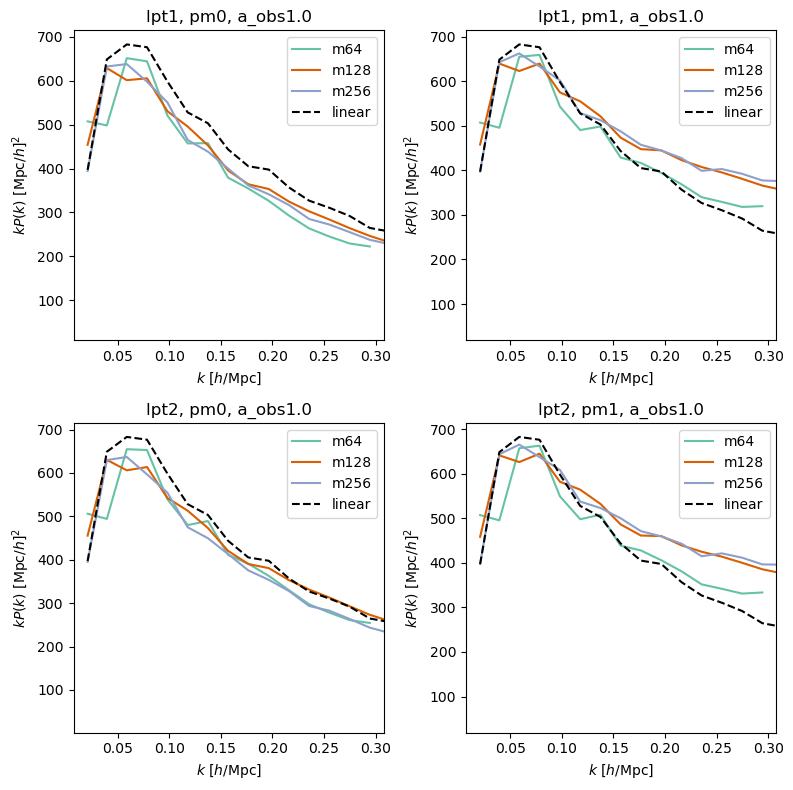

In [11]:
from montecosmo.plot import plot_pow, plot_trans, theme
theme()

plt.figure(figsize=(8, 8))
i_count = 0
for mesh_length in [64, 128, 256]:
    i_plt = 0
    for lpt_order in [1, 2]:
        for pm in [0,1]:
            kpk = kpks[i_count]
            kpklin = kpks[i_count+1]

            plt.subplot(2, 2, i_plt+1)
            plt.title(f'lpt{lpt_order}, pm{pm}, a_obs{a_obs}')

            # plot_trans(kpk[0], (kpk[1]/kpklin[1])**.5, label=f'm{mesh_length}')
            
            plot_pow(*kpk, label=f'm{mesh_length}')
            if i_count>15:
                plot_pow(*kpklin, 'k--', label='linear')
            
            plt.xlim(*plt.xlim())
        
            plt.legend()
            i_count += 2
            i_plt += 1
plt.tight_layout()

## Gaussianity

In [ ]:
from montecosmo.model import FieldLevelModel, default_config
from montecosmo.bricks import lin_power_mesh, Planck18, lpt, nbody, cic_paint, rfftk
from jaxpm.growth import growth_factor

def evolve(model, params:tuple):
    cosmology, init = params

    # Create regular grid of particles
    q = jnp.indices(model.mesh_shape).reshape(3,-1).T

    # LPT displacement at a_lpt
    # NOTE: lpt assumes given mesh follows linear pk at a=1, and then correct by growth factor for target a_lpt
    cosmology._workspace = {}  # HACK: temporary fix
    dq, p, f = lpt(cosmology, **init, positions=q, a=model.a_lpt, order=model.lpt_order)
    particles = jnp.stack([q + dq, p])

    # PM displacement from a_lpt to a_obs
    particles = nbody(cosmology, model.mesh_shape, particles, model.a_lpt, model.a_obs)
    particles = particles[-1]

    # CIC paint weighted by Lagrangian bias expansion weights
    biased_mesh = cic_paint(jnp.zeros(model.mesh_shape), particles[0])
    return biased_mesh


config = {
            'mesh_shape':3 * (256,),
            'box_shape':3 * (10000.,),
            'a_lpt':0.1,
            'a_obs':1.,
            'lpt_order':2,
            'precond':0,
            'obs':'mesh'
            }
model = FieldLevelModel(**default_config | config)

cosmology = Planck18()
pmeshk = lin_power_mesh(cosmology, model.mesh_shape, model.box_shape)
seed = jr.normal(jr.key(0), model.mesh_shape)
linmesh = jnp.fft.rfftn(seed) * pmeshk**.5
params = cosmology, {'init_mesh':linmesh}

mesh = evolve(model, params) - 1
k, pk = model.spectrum(mesh, comp=True)

pk_fn = lambda x: jnp.exp(jnp.interp(x.reshape(-1), k, jnp.log(pk), left=-jnp.inf, right=-jnp.inf)).reshape(x.shape)
kvec = rfftk(model.mesh_shape)
k_box = sum((ki  * (m / l))**2 for ki, m, l in zip(kvec, model.mesh_shape, model.box_shape))**0.5
pmeshk = pk_fn(k_box) * (model.mesh_shape / model.box_shape).prod() # NOTE: convert from (Mpc/h)^3 to cell units
gaussmesh = jnp.fft.irfftn(jnp.fft.rfftn(seed) * pmeshk**.5)

D1 = growth_factor(cosmology, jnp.atleast_1d(model.a_obs))
linmesh = jnp.fft.irfftn(linmesh * D1)

ImportError: cannot import name 'lpt' from 'montecosmo.bricks' (/feynman/home/dphp/hs276503/workspace/montecosmo_proj/src/montecosmo/montecosmo/bricks.py)

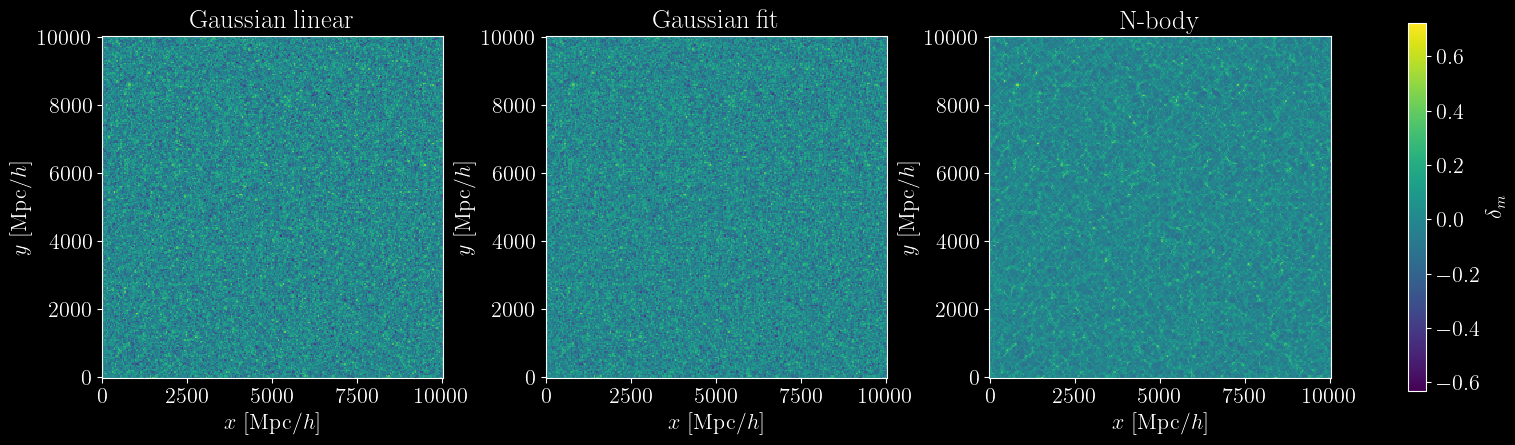

In [11]:
from montecosmo.plot import plot_mesh, theme
dark = True
theme(dark=dark, usetex=True, font_size=16)


mesh_toplot = jnp.stack([linmesh, gaussmesh, mesh])
vlim = 1e-2*5
vlim = jnp.array([vlim/2, 1-vlim/2])
vlim = jnp.quantile(mesh_toplot, vlim)
sli = 1/20

titles = ['Gaussian linear', 'Gaussian fit', 'N-body']

plt.figure(figsize=(17, 5))
for i_plt, m in enumerate(mesh_toplot):
    plt.subplot(1, 3, i_plt+1)
    plt.title(titles[i_plt])
    plot_mesh(m, model.box_shape, sli=sli, vlim=vlim)
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.colorbar(ax=plt.gcf().axes).set_label("$\\delta_m$")
fina = f'gaussinity_b{model.box_shape[0]:.0f}'
if dark: fina += '_dk'
plt.savefig(fina+'.png', dpi=200)

## BullFrog

In [3]:
from montecosmo.model import FieldLevelModel, default_config
from montecosmo.bricks import lin_power_mesh, Planck18, rsd as rsd_bf
from montecosmo.nbody import lpt_fpm, nbody_tsit5, nbody_bf, nbody_bf_scan, rsd_fpm
from jaxpm.painting import cic_paint
from jaxpm.growth import growth_factor, growth_rate
import jax_cosmo as jc

a_obs = 1.
a_lpt = 0.005 
solvers = ['bullfrog', 'tsit5']
mesh_length, box_length = 64, 640.
lpt_order = 1
grad_fd = False
rsd = False
los = (0.,0.,1.)

config = {
            'mesh_shape':3 * (mesh_length,),
            'box_shape':3 * (box_length,),
            'a_obs':a_obs,
            'lpt_order':lpt_order,
            'precond':'kaiser',
            'observable':'field'
            }

def evolve(model, params:tuple, solver='bullfrog', grad_fd=False, lap_fd=False, 
           rsd=False, n_steps=50, tol=1e-4, a_lpt=0.1): # grad_fd=False, lap_fd=False, no deconv, for pmwd
    cosmology, init = params

    # Create regular grid of particles
    pos = jnp.indices(model.mesh_shape, dtype=float).reshape(3,-1).T

    if solver == 'bullfrog':
        cosmology._workspace = {}  # HACK: temporary fix
        part = nbody_bf_scan(cosmology, **init, pos=pos, a=model.a_obs, n_steps=n_steps, grad_fd=grad_fd, lap_fd=lap_fd)
        pos, vel = tree.map(lambda x: x[-1], part)

        if rsd:
            # RSD displacement at a_obs
            pos += rsd_bf(cosmology, model.a_obs, vel, los=los)
            vel = vel * growth_factor(cosmology, model.a_obs) * growth_rate(cosmology, model.a_obs)
        else: 
            vel = None

    elif solver == 'tsit5':
        # LPT displacement at a_lpt
        # NOTE: lpt assumes given mesh follows linear pk at a=1, and then correct by growth factor for target a_lpt
        cosmology._workspace = {}  # HACK: temporary fix
        dpos, vel = lpt_fpm(cosmology, **init, pos=pos, a=a_lpt, order=model.lpt_order, grad_fd=grad_fd, lap_fd=lap_fd)
        part = (pos + dpos, vel)

        # PM displacement from a_lpt to a_obs
        part = nbody_tsit5(cosmology, model.mesh_shape, part, a_lpt, model.a_obs, 
                                tol=tol, grad_fd=grad_fd, lap_fd=lap_fd)
        pos, vel = tree.map(lambda x: x[-1], part)

        if rsd:
            # RSD displacement at a_obs
            pos += rsd_fpm(cosmology, model.a_obs, vel, los=los)
            vel = vel / (jc.background.Esqr(cosmology, model.a_obs)**.5 * model.a_obs**2)
        else: 
            vel = None

    # CIC paint weighted by Lagrangian bias expansion weights
    biased_mesh = cic_paint(jnp.zeros(model.mesh_shape), pos)
    return biased_mesh, vel

### Growth functions

2025-02-19 21:24:28.791232: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


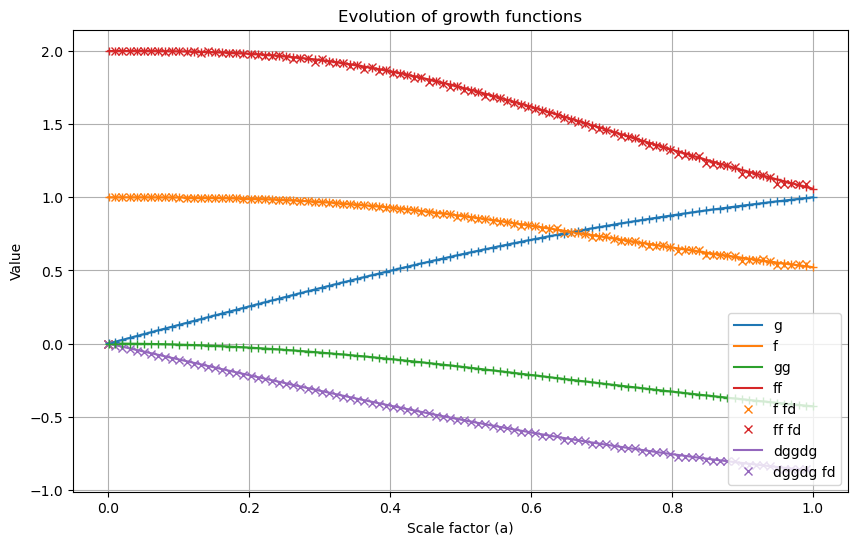

In [4]:
from jaxpm.growth import growth_factor as g, growth_rate as f, growth_factor_second as gg, growth_rate_second as ff
from montecosmo.bricks import Planck18
cosmo = Planck18()
a = jnp.linspace(0, 1, 100)
gs = g(cosmo, a)
f_values = f(cosmo, a)
gg_values = gg(cosmo, a)*(-3/7)
ff_values = ff(cosmo, a)
from montecosmo.nbody import g2a, g2gg, g2f, g2ff
aa = g2a(cosmo, gs)
fs = g2f(cosmo, gs)
ggs = g2gg(cosmo, gs)
ffs = g2ff(cosmo, gs)

dg = jnp.diff(jnp.log(gs))/jnp.diff(jnp.log(a))
dgg = jnp.diff(jnp.log(gg_values*-1))/jnp.diff(jnp.log(a))

def dggdg(cosmo, g):
    gg, f, ff = g2gg(cosmo, g), g2f(cosmo, g), g2ff(cosmo, g)
    return jnp.where(g==0., 0., gg * ff / (g * f))
dggdgs_fd = jnp.diff(gg_values)/jnp.diff(gs)
dggdgs = dggdg(cosmo, gs)

plt.figure(figsize=(10, 6))
plt.plot(a, gs, 'C0', label='g')
plt.plot(a, f_values, 'C1', label='f')
plt.plot(a, gg_values, 'C2', label='gg')
plt.plot(a, ff_values, 'C3', label='ff')

plt.plot(a[:-1], dg, 'C1x', label='f fd')
plt.plot(a[:-1], dgg, 'C3x', label='ff fd')

plt.plot(a, dggdgs, 'C4', label='dggdg')
plt.plot(a[:-1], dggdgs_fd, 'C4x', label='dggdg fd')

plt.plot(aa, gs, 'C0+')
plt.plot(aa, fs, 'C1+')
plt.plot(aa, ggs, 'C2+')
plt.plot(aa, ffs, 'C3+')
plt.xlabel('Scale factor (a)')
plt.ylabel('Value')
plt.legend()
plt.title('Evolution of growth functions')
plt.grid(True)
plt.show()


### PMWD comparison

In [ ]:
from pmwd import Configuration, Cosmology, SimpleLCDM,\
    boltzmann, linear_power, growth, white_noise, linear_modes, nbody as nbody_pmwd, lpt as lpt_pmwd
import jax
from jaxpm.growth import growth_factor
import jax_cosmo as jc


def run_pmwd(cosmo=(0.2607, 0.8102), a_lpt=.1, a_obs=1., lpt_order=1, rsd=False, box_length=640., mesh_length=256, pmeshk=None):
    ptcl_spacing = box_length / mesh_length # Mpc/h
    ptcl_grid_shape = (mesh_length,)*3
    mesh_shape = np.array((mesh_length,)*3)
    box_shape = np.array((box_length,)*3)
    zeros_mesh = jnp.zeros(mesh_shape)
    
    # jax.config.update("jax_enable_x64", False)
    conf = Configuration(ptcl_spacing, ptcl_grid_shape, mesh_shape=1, 
                         a_start=a_lpt, a_stop=a_obs, lpt_order=lpt_order,
                         cosmo_dtype=jnp.float32, a_nbody_maxstep=1/64)
    Omega_c, sigma8 = cosmo
    Omega_b = 0.0490
    # XXX: sigma8 redshift dependant???
    cosmo = Cosmology.from_sigma8(conf, sigma8=sigma8, n_s=0.9665, Omega_m=Omega_c+Omega_b, Omega_b=Omega_b, h=0.6766)
    # cosmo = Cosmology(conf, A_s_1e9=np.exp(3.047)/10, n_s=0.9665, Omega_m=0.3097, Omega_b=0.0490, h=0.6766)
    # cosmo = Cosmology(conf, A_s_1e9=sigma8**2, n_s=0.9665, Omega_m=Omega_c+Omega_b, Omega_b=Omega_b, h=0.6766)
    cosmo = boltzmann(cosmo, conf)

    cosmology = Planck18(Omega_c=Omega_c, sigma8=sigma8)
    if pmeshk is None:
        pmeshk = lin_power_mesh(cosmology, mesh_shape, box_shape)
    init_modes = jr.normal(jr.key(0), mesh_shape)
    init_modes = jnp.fft.rfftn(init_modes) * pmeshk**.5

    init_modes *= growth_factor(cosmology, jnp.atleast_1d(a_lpt)) / growth(a_lpt, cosmo, conf, order=1) * conf.ptcl_cell_vol
    ptcl, obsvbl = lpt_pmwd(init_modes, cosmo, conf)
    # return ptcl.disp/ptcl_spacing

    # modes = white_noise(0, conf)
    # field = jr.normal(jr.key(0), mesh_shape)
    # modes = jnp.fft.rfftn(field, norm="ortho")
    # modes = linear_modes(modes, cosmo, conf)        
    # ptcl, obsvbl = lpt_pmwd(modes, cosmo, conf)
    
    ptcl, obsvbl = nbody_pmwd(ptcl, obsvbl, cosmo, conf)
    # jax.config.update("jax_enable_x64", False)
    if rsd:
        dx_rsd = ptcl.vel / (jnp.sqrt(jc.background.Esqr(cosmology, a_obs)) * a_obs**2)
        pos = ptcl.pos() + dx_rsd * jnp.array([0,0,1])
    else:
        pos = ptcl.pos()
    
    # return scatter(ptcl, conf)
    return cic_paint(zeros_mesh, pos/ptcl_spacing)

In [28]:
import time
solvers = ['bullfrog', 'tsit5', 'pmwd']
model = FieldLevelModel(**default_config | config)
print(model)

cosmo = jnp.array([0.2607, 0.8102])
Omega_c, sigma8 = cosmo
cosmology = Planck18(Omega_c=Omega_c, sigma8=sigma8)
pmeshk = lin_power_mesh(cosmology, model.mesh_shape, model.box_shape)
linmesh = jr.normal(jr.key(0), model.mesh_shape)
linmesh = jnp.fft.rfftn(linmesh) * pmeshk**.5
init = {'init_mesh':linmesh}
params = cosmology, init

D1 = growth_factor(cosmology, a_obs)
linmesh = jnp.fft.irfftn(linmesh * D1)
kpklin = model.spectrum(linmesh)

# jax.config.update("jax_enable_x64", False)
start_time = time.time()
mesh_pmwd = run_pmwd(cosmo=cosmo, a_lpt=a_lpt, a_obs=a_obs, lpt_order=lpt_order, rsd=rsd, box_length=box_length, mesh_length=mesh_length)
print(f'pmwd time: {time.time()-start_time:.2f}s')

start_time = time.time()
mesh_ts, dx_ts = evolve(model, params, solver='tsit5', grad_fd=grad_fd, lap_fd=False, rsd=rsd, a_lpt=a_lpt)
print(f'tsit5 time: {time.time()-start_time:.2f}s')

start_time = time.time()
mesh_bf, dx_bf = evolve(model, params, solver='bullfrog', grad_fd=grad_fd, lap_fd=False, rsd=rsd, a_lpt=a_lpt)
print(f'bullfrog time: {time.time()-start_time:.2f}s')
# jax.config.update("jax_enable_x64", False)

ref = linmesh
comp = (0, 2)

# ref = mesh_bf
# comp = 2

kptcs = []
kptc = model.powtranscoh(ref, mesh_bf, comp=comp)
kptcs.append(kptc)
kptc = model.powtranscoh(ref, mesh_ts, comp=comp)
kptcs.append(kptc)
kptc = model.powtranscoh(ref, mesh_pmwd, comp=comp)
kptcs.append(kptc)

mses = []
mse = jnp.mean((ref - mesh_bf)**2)
mses.append(mse)
mse = jnp.mean((ref - mesh_ts)**2)
mses.append(mse)
mse = jnp.mean((ref - mesh_pmwd)**2)
mses.append(mse)

# CONFIG
{'a_obs': 1.0,
 'box_shape': array([640., 640., 640.]),
 'evolution': 'lpt',
 'gxy_density': 0.001,
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'loc_fid': 0.3111,
                         'low': 0.05,
                         'scale': 0.5,
                         'scale_fid': 0.02},
             'b1': {'group': 'bias',
                    'label': '{b}_1',
                    'loc': 1.0,
                    'loc_fid': 1.0,
                    'scale': 0.5,
                    'scale_fid': 0.04},
             'b2': {'group': 'bias',
                    'label': '{b}_2',
                    'loc': 0.0,
                    'loc_fid': 0.0,
                    'scale': 2.0,
                    'scale_fid': 0.02},
             'bn2': {'group': 'bias',
                     'label': '{b}_{\\nabla^2}',
                     'loc': 0.0,
 

[2.456 2.371 2.378]


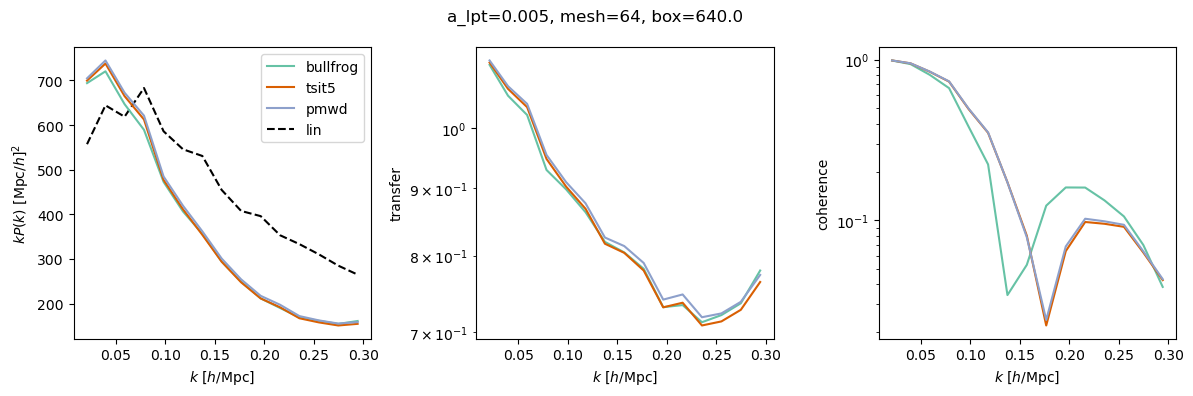

In [29]:
from montecosmo.plot import plot_powtranscoh, plot_pow, theme, SetDark2
theme()
log = False

plt.figure(figsize=(12,4))
for i_plt, kptc in enumerate(kptcs):
    plot_powtranscoh(*kptc, log=log, label=f"{solvers[i_plt]}")
plt.subplot(1,3,1)
plot_pow(*kpklin, 'k--', log=log, label=f"lin", zorder=-1)
plt.legend()
plt.suptitle(f"{a_lpt=}, mesh={mesh_length}, box={box_length}")
plt.tight_layout()
# plt.savefig(f'pmsolv_al{a_lpt}_m{mesh_length}_gradfd{grad_fd:d}_rsd{rsd:d}.png', dpi=200)
print(np.array(mses))

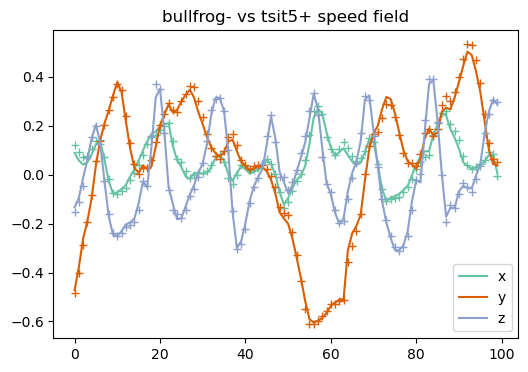

In [30]:
i_plt = 100
plt.figure(figsize=(6, 4))
for i_c, coord in enumerate(['x', 'y', 'z']):
    plt.plot(dx_bf[:i_plt, i_c], c=SetDark2(i_c), label=coord)
    plt.plot(dx_ts[:i_plt, i_c], '+', c=SetDark2(i_c))
plt.title(f"{solvers[0]}- vs {solvers[1]}+ speed field")
plt.legend()
plt.show()

### Temporal convergence

In [7]:
import time
kptcs = []
a_obs = .5
a_lpt = 1e-2
# solvers = ['bullfrog', 'tsit5']
solvers = ['tsit5', 'bullfrog']
# solvers = ['bullfrog']
mesh_length = 256
box_length = 640.
sli = slice(0, -1)
tols =  [1e-7, 1e-5, 1e-3, 1e-1, 1e4][sli]
# nstps = 6*np.array([94, 18, 8, 5, 3])[sli] # 6 evals per dopri5/tsit5 steps
nstps = np.array([94, 18, 8, 5, 3])[sli] # 6 evals per dopri5/tsit5 steps
# nstps = [100, 50, 10, 5, 3]

config = {
            'mesh_shape':3 * (mesh_length,),
            'box_shape':3 * (box_length,),
            'a_obs':a_obs,
            'lpt_order':2,
            'precond':'kaiser',
            'observable':'field'
            }
model = FieldLevelModel(**default_config | config)
cosmology = Planck18()
pmeshk = lin_power_mesh(cosmology, model.mesh_shape, model.box_shape)
linmesh = jr.normal(jr.key(0), model.mesh_shape)
linmesh = jnp.fft.rfftn(linmesh) * pmeshk**.5
init = {'init_mesh':linmesh}
params = cosmology, init

i_count = 0
for nstp, tol in zip(nstps, tols):
    for solver in solvers:
        start_time = time.time()
        mesh, moment = evolve(model, params, solver=solver, grad_fd=False, lap_fd=False, n_steps=nstp, tol=tol, a_lpt=a_lpt)
        print(f'{solver} time: {time.time()-start_time:.2f}s')
        if i_count == 0:
            print(solver)
            mesh_ref = mesh
            D1 = growth_factor(cosmology, a_obs)
            linmesh = jnp.fft.irfftn(linmesh * D1)
            kpklin = model.spectrum(linmesh)
        i_count+=1

        kptc = model.powtranscoh(mesh_ref, mesh, comp=2)
        kptcs.append(kptc)

tsit5 n_steps: 46
tsit5 time: 15.41s
tsit5
bullfrog time: 4.68s
tsit5 n_steps: 10
tsit5 time: 6.42s
bullfrog time: 1.81s
tsit5 n_steps: 5
tsit5 time: 5.37s
bullfrog time: 1.42s
tsit5 n_steps: 4
tsit5 time: 4.95s
bullfrog time: 1.32s


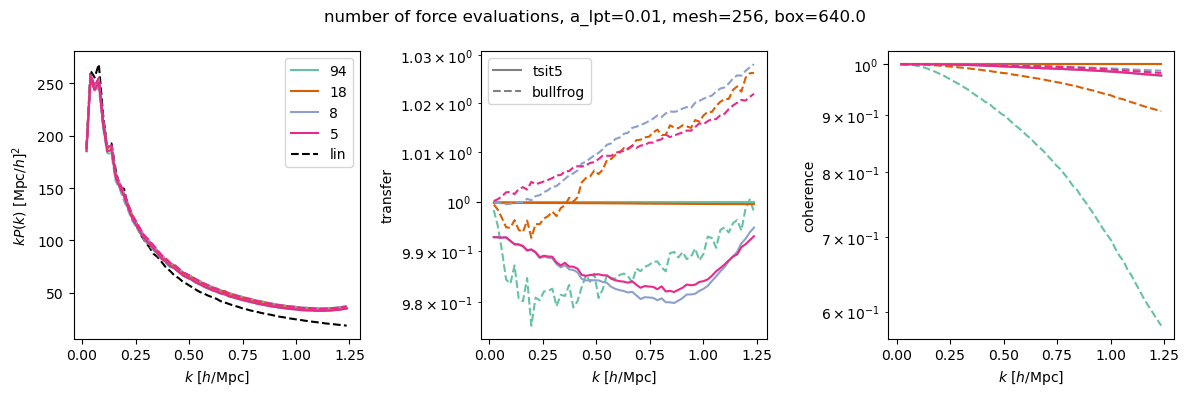

In [8]:
from montecosmo.plot import plot_powtranscoh, plot_pow, theme, SetDark2
theme()
log = False
plt.figure(figsize=(12,4))
i_count = 0
lss = ['-', '--']
for i_c, (nstp, tol) in enumerate(zip(nstps, tols)):
    plot_powtranscoh(*kptcs[i_count], lss[0], log=log, c=SetDark2(i_c), label=f"{nstp}")
    plot_powtranscoh(*kptcs[i_count+1], lss[1], log=log, c=SetDark2(i_c))
    i_count+=len(solvers)
plt.subplot(1,3,1)
plot_pow(*kpklin, 'k--', log=log, label=f"lin", zorder=-1)
plt.legend()

from matplotlib.lines import Line2D; from matplotlib.patches import Patch
# handles, labels = plt.gca().get_legend_handles_labels()
handles = []
for i_m, (ls, solver) in enumerate(zip(lss, solvers)):
    handles.append(Line2D([], [], color='grey', linestyle=ls, label=solver))
plt.subplot(132)
plt.legend(handles=handles)
plt.suptitle(f"number of force evaluations, {a_lpt=}, mesh={mesh_length}, box={box_length}")
plt.tight_layout()
# plt.savefig(f'pmsolv_al{a_lpt}_m{mesh_length}_nsteps.png', dpi=200)

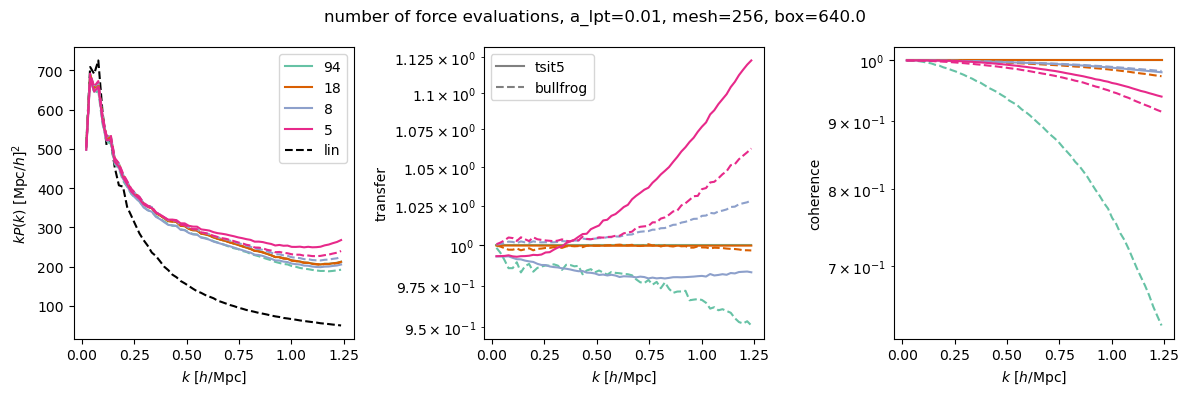

In [ ]:
from montecosmo.plot import plot_powtranscoh, plot_pow, theme, SetDark2
theme()
log = False
plt.figure(figsize=(12,4))
i_count = 0
lss = ['-', '--']
for i_c, (nstp, tol) in enumerate(zip(nstps, tols)):
    plot_powtranscoh(*kptcs[i_count], lss[0], log=log, c=SetDark2(i_c), label=f"{nstp}")
    plot_powtranscoh(*kptcs[i_count+1], lss[1], log=log, c=SetDark2(i_c))
    i_count+=len(solvers)
plt.subplot(1,3,1)
plot_pow(*kpklin, 'k--', log=log, label=f"lin", zorder=-1)
plt.legend()

from matplotlib.lines import Line2D; from matplotlib.patches import Patch
# handles, labels = plt.gca().get_legend_handles_labels()
handles = []
for i_m, (ls, solver) in enumerate(zip(lss, solvers)):
    handles.append(Line2D([], [], color='grey', linestyle=ls, label=solver))
plt.subplot(132)
plt.legend(handles=handles)
plt.suptitle(f"number of force evaluations, {a_lpt=}, mesh={mesh_length}, box={box_length}")
plt.tight_layout()
# plt.savefig(f'pmsolv_al{a_lpt}_m{mesh_length}_nsteps.png', dpi=200)

### Spatial convergence

In [92]:
import time

kpks = []
a_obs = 1.
solvers = ['bullfrog', 'tsit5']
lengths = [64, 128, 256]
lpt_orders = [2]
pms = [1]

for solver in solvers:
    for mesh_length in lengths:
        for lpt_order in lpt_orders:
            for pm in pms:
                a_lpt = 0.001 if pm else a_obs
                config = {
                            'mesh_shape':3 * (mesh_length,),
                            'box_shape':3 * (640.,),
                            'a_lpt':a_lpt,
                            'a_obs':a_obs,
                            'lpt_order':lpt_order,
                            'precond':0,
                            'obs':'mesh'
                            }
                model = FieldLevelModel(**default_config | config)

                cosmology = Planck18()
                pmeshk = lin_power_mesh(cosmology, model.mesh_shape, model.box_shape)
                linmesh = jr.normal(jr.key(0), model.mesh_shape)
                linmesh = jnp.fft.rfftn(linmesh) * pmeshk**.5
                init = {'init_mesh':linmesh}
                params = cosmology, init

                start_time = time.time()
                mesh = evolve(model, params, solver=solver, grad_fd=False, lap_fd=False).block_until_ready()
                print(f'{solver} time: {time.time()-start_time:.2f}s')
                kpk = model.spectrum(mesh, comp=True)
                kpks.append(kpk)

                D1 = growth_factor(cosmology, a_obs)
                kpklin = model.spectrum(jnp.fft.irfftn(linmesh * D1))
                kpks.append(kpklin)

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


rsd
bullfrog time: 0.76s


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


rsd
bullfrog time: 0.79s


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


rsd
bullfrog time: 1.17s


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


n_solvsteps: 6
tsit5 time: 2.16s


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


n_solvsteps: 7
tsit5 time: 1.26s


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


n_solvsteps: 12
tsit5 time: 3.09s


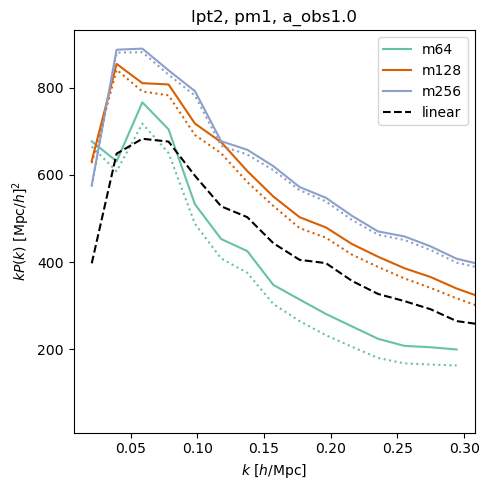

In [93]:
from montecosmo.plot import plot_pow, plot_trans, theme, SetDark2
theme()

plt.figure(figsize=(5, 5))
i_count = 0
for i_s, solver in enumerate(solvers):
    for i_c, mesh_length in enumerate(lengths):
        i_plt = 0
        for lpt_order in lpt_orders:
            for pm in pms:
                kpk = kpks[i_count]
                kpklin = kpks[i_count+1]

                plt.subplot(len(lpt_orders), len(pms), i_plt+1)
                plt.title(f'lpt{lpt_order}, pm{pm}, a_obs{a_obs}')

                style = '-' if solver == 'bullfrog' else ':'
                label = f'm{mesh_length}' if solver == 'bullfrog' else None

                # plot_trans(kpk[0], (kpk[1]/kpklin[1])**.5, label=f'm{mesh_length}')

                plot_pow(*kpk, style, c=SetDark2(i_c), label=label)
                if i_c==len(lengths)-1 and i_s==len(solvers)-1:
                    plot_pow(*kpklin, 'k--', label='linear')
                
                plt.xlim(*plt.xlim())
            
                plt.legend()
                i_count += 2
                i_plt += 1
plt.tight_layout()
# plt.savefig(f'pmsolvers_resol_nodeconv_gradfd1.png', dpi=200)

### Gradients

In [47]:
from jax import value_and_grad
from pmwd import Configuration, Cosmology, SimpleLCDM,\
    boltzmann, linear_power, growth, white_noise, linear_modes, nbody as nbody_pmwd, lpt as lpt_pmwd, scatter
import jax
from pmwd.pm_util import fftinv

def small_model(cosmo, model, solver='bullfrog', pmeshk=None):
    Omega_c, sigma8 = cosmo
    cosmology = Planck18(Omega_c=Omega_c, sigma8=sigma8)
    if pmeshk is None:
        pmeshk = lin_power_mesh(cosmology, model.mesh_shape, model.box_shape)
    linmesh = jr.normal(jr.key(0), model.mesh_shape)
    linmesh = jnp.fft.rfftn(linmesh) * pmeshk**.5
    init = {'init_mesh':linmesh}
    params = cosmology, init

    D1 = growth_factor(cosmology, model.a_obs)
    linmesh = jnp.fft.irfftn(linmesh * D1)

    mesh, moment = evolve(model, params, solver=solver, n_steps=50)
    # mesh = model.spectrum(mesh)[1]
    return mesh, linmesh

a_obs = 1.
a_lpt = 0.005
mesh_length = 128
box_length = 640.

config = {
            'mesh_shape':3 * (mesh_length,),
            'box_shape':3 * (box_length,),
            'a_lpt':a_lpt,
            'a_obs':a_obs,
            'lpt_order':1,
            'precond':0,
            'obs':'mesh'
            }
model = FieldLevelModel(**default_config | config)
pmeshk = lin_power_mesh(Planck18(), model.mesh_shape, model.box_shape)

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


pmwd


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/p

tsit5
bullfrog


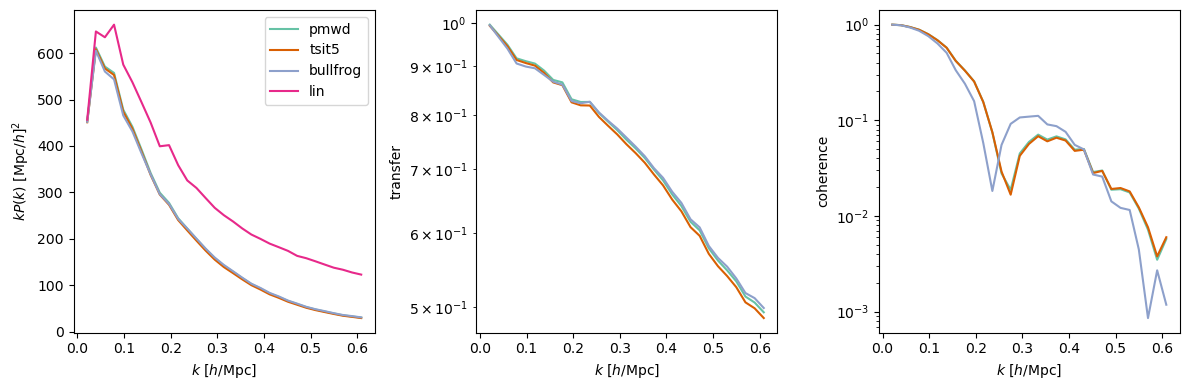

In [ ]:
def mse_fn(cosmo, ref, solver):
    mesh, _ = small_model(cosmo, model=model, solver=solver, pmeshk=pmeshk)
    mesh2 = model.powtranscoh(ref, mesh)
    ref2 = model.spectrum(ref)
    return jnp.mean((ref2[1] - mesh2[1])**2), mesh2

def mse_fn_pmwd(cosmo, ref):
    mesh = run_pmwd(cosmo, a_lpt=a_lpt, a_obs=a_obs, box_length=box_length, mesh_length=mesh_length, pmeshk=pmeshk)
    mesh2 = model.powtranscoh(ref, mesh)
    ref2 = model.spectrum(ref)
    return jnp.mean((ref2[1] - mesh2[1])**2), mesh2

cosmo = jnp.array([0.2607, 0.8102])
eps = 0.05
# cosmo += jnp.array([1., 0.])*eps
mesh, linmesh = small_model(cosmo, model, solver='bullfrog', pmeshk=pmeshk)
ref = linmesh
kpowlin = model.spectrum(linmesh)
# ks, ref = model.spectrum(mesh)

print("pmwd")
jax.config.update("jax_enable_x64", False)
ptc_pmwd = (lambda x: mse_fn_pmwd(x, ref=ref)[1])(cosmo)
print("tsit5")
ptc_t5 = (lambda x: mse_fn(x, ref=ref, solver='tsit5')[1])(cosmo)
print("bullfrog")
ptc_bf = (lambda x: mse_fn(x, ref=ref, solver='bullfrog')[1])(cosmo)

from montecosmo.plot import plot_pow, plot_powtranscoh, theme
theme()
plt.figure(figsize=(12, 4))
plot_powtranscoh(*ptc_pmwd, label='pmwd')
plot_powtranscoh(*ptc_t5, label='tsit5')
plot_powtranscoh(*ptc_bf, label='bullfrog')
plt.subplot(131)
plot_pow(*kpowlin, label='lin')
plt.legend()
plt.tight_layout()

In [49]:

print("pmwd")
jax.config.update("jax_enable_x64", False)
vg_pmwd = value_and_grad(lambda x: mse_fn_pmwd(x, ref=ref)[0])(cosmo)
print("tsit5")
vg_t5 = value_and_grad(lambda x: mse_fn(x, ref=ref, solver='tsit5')[0])(cosmo)
print("bullfrog")
vg_bf = value_and_grad(lambda x: mse_fn(x, ref=ref, solver='bullfrog')[0])(cosmo)
vg_pmwd, vg_t5, vg_bf, 


pmwd


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/p

tsit5
bullfrog


((Array(290228.3, dtype=float32), Array([nan,  0.], dtype=float32)),
 (Array(319886.1, dtype=float32), Array([100708.,      0.], dtype=float32)),
 (Array(349232.84, dtype=float32),
  Array([12290.118,     0.   ], dtype=float32)))

In [51]:
def value_and_grad2(f):
    eps = 1e-3
    eps1 = jnp.array([eps, 0.])
    eps2 = jnp.array([0., eps])
    def f2(x):
        x = jnp.asarray(x)
        fd1 = (f(x + eps1) - f(x - eps1)) / (2 * eps)
        fd2 = (f(x + eps2) - f(x - eps2)) / (2 * eps)
        return f(x), jnp.array([fd1, fd2])
    return f2

print("pmwd")
jax.config.update("jax_enable_x64", False)
vg_pmwd = value_and_grad2(lambda x: mse_fn_pmwd(x, ref=ref)[0])(cosmo)
print("tsit5")
vg_t5 = value_and_grad2(lambda x: mse_fn(x, ref=ref, solver='tsit5')[0])(cosmo)
print("bullfrog")
vg_bf = value_and_grad2(lambda x: mse_fn(x, ref=ref, solver='bullfrog')[0])(cosmo)
vg_pmwd, vg_t5, vg_bf, 

pmwd


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/p

tsit5
bullfrog


((Array(290228.44, dtype=float32),
  Array([17187.498,   750.   ], dtype=float32)),
 (Array(319891.5, dtype=float32),
  Array([104796.87 ,   1140.625], dtype=float32)),
 (Array(349234.44, dtype=float32),
  Array([12031.249,  -828.125], dtype=float32)))

## Whole Model Convergence

Running for nbody_steps=4


2025-02-19 21:09:10.212528: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


deconv
deconv
Running for nbody_steps=16
deconv
deconv
Running for nbody_steps=64
deconv
deconv
Running for nbody_steps=256
deconv
deconv


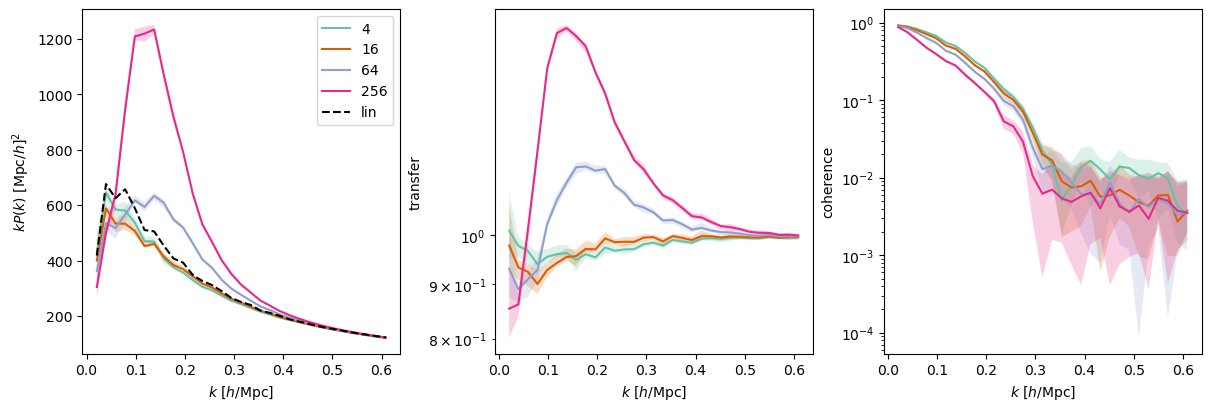

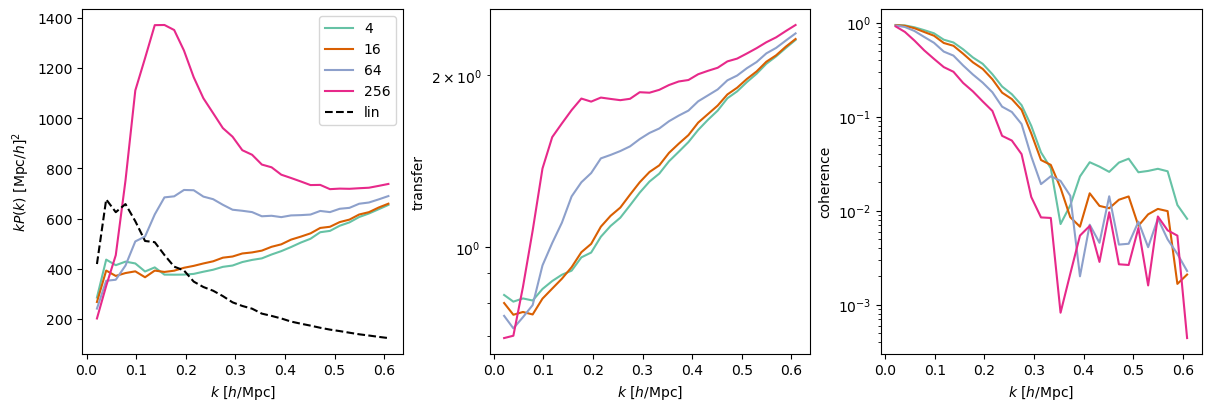

In [2]:
from montecosmo.model import FieldLevelModel, default_config
from montecosmo.plot import plot_pow, plot_powtranscoh, plot_coh, theme
from montecosmo.nbody import a2g
from montecosmo.bricks import get_cosmology
theme()
model = FieldLevelModel(**default_config)

a_obss = [0.1, 0.5, 1.]
a_obs = 0.5
n_stepss = [4, 16, 64, 256]
# kpow0s = []
# kptcs = []
# kptc_obss = []

prob = 0.95
plt.figure(1, figsize=(12, 4), layout='constrained')
plt.figure(2, figsize=(12, 4), layout='constrained')
# for i_a, a_obs in enumerate(a_obss):
for i_a, n_steps in enumerate(n_stepss):
    # print(f"Running for a_obs={a_obs}")
    print(f"Running for nbody_steps={n_steps}")

    model.a_obs = a_obs
    model.mesh_shape = 3 * (128,)
    model.box_shape = 5 * np.array(model.mesh_shape)
    model.evolution = 'nbody'
    model.lpt_order = 1
    model.nbody_steps = n_steps

    model.loc_fid['b1'] = 0.
    truth = {'Omega_m': 0.3111, 
            'sigma8': 0.8102, 
            'b1': 0.,
            'b2':0., 
            'bs2':0., 
            'bn2': 0.}
    
    truth = model.predict(samples=truth, hide_base=False, hide_samp=False, frombase=True)
    delta_obs = truth['obs'] - 1
    kaiser_post = jit(vmap(partial(model.kaiser_post, delta_obs=delta_obs, base=True)))(jr.split(jr.key(42), 16))

    mesh0 = jnp.fft.irfftn(truth['init_mesh'])
    kpow0 = model.spectrum(mesh0)
    # kpow0s.append(kpow0)

    kptc = vmap(lambda x: model.powtranscoh(mesh0, jnp.fft.irfftn(x['init_mesh'])))(kaiser_post)
    # kptcs.append(kptc)

    kptc_obs = model.powtranscoh(mesh0, delta_obs)
    # kptc_obss.append(kptc_obs)

    plt.figure(1)
    plot_powtranscoh(*jnp.median(jnp.stack(kptc), 1), label=f'{n_steps}')
    plot_powtranscoh(*kptc, fill=prob)

    plt.subplot(131)
    if i_a == len(n_stepss) - 1:
        plot_pow(*kpow0, 'k--', label='lin')
        # plot_pow(*kptc_obs[:2], ':', c='grey', label='obs')
        # plt.subplot(133)
        # plot_coh(kptc_obs[0], kptc_obs[-1], ':', c='grey', label='obs')
    plt.subplot(131)
    plt.legend()


    plt.figure(2)
    plot_powtranscoh(*kptc_obs, label=f'{n_steps}')

    plt.subplot(131)
    if i_a == len(n_stepss) - 1:
        plot_pow(*kpow0, 'k--', label='lin')
    plt.legend()

save_dir = './figs/'
title = f"m{model.mesh_shape[0]}_b{model.box_shape[0]}_a{a_obs}_e{model.evolution}"
title = "deconv2_" + title
plt.figure(1)
plt.savefig(save_dir+'kaipost_nsteps_'+title+'.svg', bbox_inches='tight')
plt.figure(2)
plt.savefig(save_dir+'obs_nsteps_'+title+'.svg', bbox_inches='tight')